# This notebook is intended to generate color images by stacking multi-band images

### import packages

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import astropy.io.fits as pyfits
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
#from image_registration import chi2_shift
#from image_registration.fft_tools import shift
import glob

In [2]:
files = glob.glob('*fits')
filters = []
for file in files:
    _filter = pyfits.getheader(file)['FILTER']
    filters.append(_filter)
filters = np.array(filters)
files = np.array(files)
print ('All the filters we have: ', np.unique(filters))

All the filters we have:  ['B' 'R' 'V']


In [3]:
info = {}
for _filt in np.unique(filters):
    filt_filename = files[np.where(filters == _filt)[0]]
    info.update({_filt: filt_filename})
info

{'B': array(['M83_AP_6150365_B_000.fits'], dtype='<U25'),
 'R': array(['M83_AP_6150365_R_002.fits'], dtype='<U25'),
 'V': array(['M83_AP_6150365_V_001.fits'], dtype='<U25')}

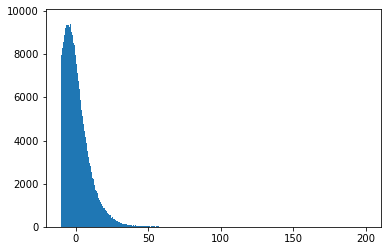

In [4]:
data = pyfits.getdata(info['B'][0])
image_hist = plt.hist(data.flatten(), bins=1000, range=(-10,200))

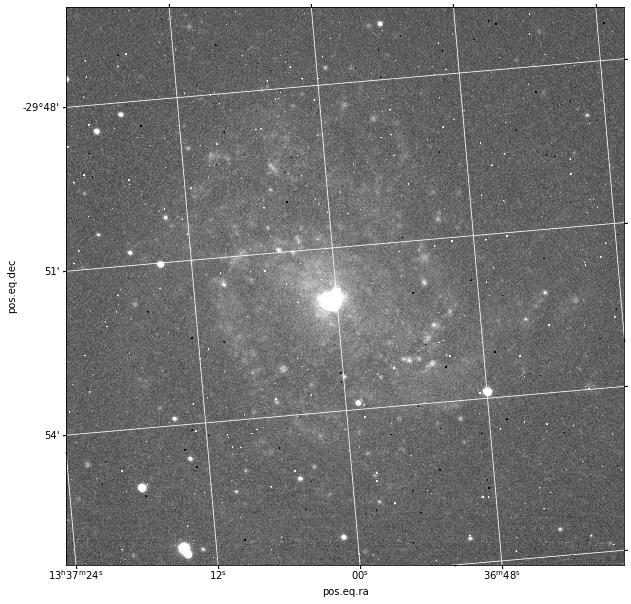

In [5]:
hdu = pyfits.open(info['B'][0])[0]
wcs = WCS(hdu.header)
fig= plt.figure(figsize=(10,12))
ax = plt.subplot(projection=wcs)
data = pyfits.getdata(info['B'][0])
#stack = (band_image['B']['data']+band_image['V']['data']+band_image['rp']['data'])
ax.imshow(data, origin='lower', cmap='gray', vmin=-40, vmax=50)#interpolation='nearest'
#or use np.quantile(data, [0.02, 0.98]) to the proper vmin and vmax
ax.grid(color='white', ls='solid')

In [6]:
image_size = np.shape(data)
image_size

(1024, 1024)

In [7]:
band_image = {}
for band in info.keys():
    _data = np.zeros(image_size)
    for file in info[band]:
        _data += pyfits.getdata(file)
    band_image.update({band: _data/2})
print(band_image)

{'B': array([[-11.80839825,  -4.1291399 ,  -2.2096858 , ...,  -1.57728374,
         13.05978203,  -8.51736164],
       [ -9.44765472,  -6.50496387, -10.92332172, ...,  -6.40772915,
        -13.05541801,  -2.0104785 ],
       [ 11.3069725 , -18.66721153,  -1.54947209, ...,  53.49894714,
         -5.06072474,  -0.66365159],
       ...,
       [ -1.77464259,  -3.94436836,  -0.26960191, ...,  -2.80059958,
          5.93032789,   0.38022321],
       [  3.52647209,  -0.69073981,  -1.83388019, ...,   2.38158083,
         -5.01306343,  -7.19173813],
       [  2.63631845,  12.29345417,  -3.88971567, ...,  -8.10939598,
        -10.4685936 ,   1.14001727]]), 'R': array([[ 8.14933586, 10.51801109,  9.70883751, ..., 10.00543785,
        10.26822567, 10.82292461],
       [10.87886429, 15.51201439, -2.07044315, ..., 11.65249348,
         3.67269945,  4.6680584 ],
       [13.57395458,  3.22523904,  9.5207386 , ..., 55.64938354,
         6.27117252,  0.88394493],
       ...,
       [10.9464798 , -5.523

<ipython-input-8-f41e1c882125>:15: RuntimeWarning: invalid value encountered in power
  simpleRGB[:,:,i]=(data*scale_factor[i])**1.5
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


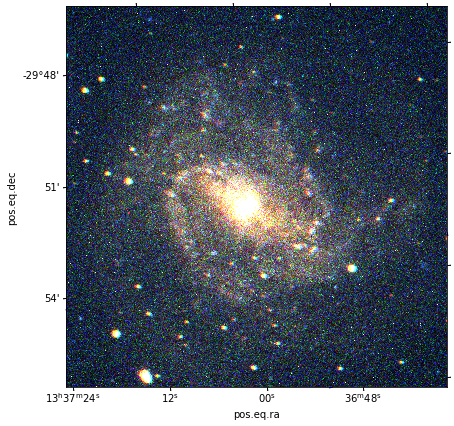

In [8]:
hdu = pyfits.open(info['B'][0])[0]
wcs = WCS(hdu.header)
bands = ['R', 'V', 'B'] #in order RGB
scale_factor = np.array([1, 0.95, 1])*1.
size = 1024
simpleRGB = []
simpleRGB=np.zeros((size,size,3),dtype=float)

ref = band_image['B'].copy()
for i in range(len(bands)):
    data = band_image[bands[i]].copy()
    min_value = np.quantile(data, [0.02, 1-0.02])[0]
    max_value = np.quantile(data, [0.02, 1-0.02])[1]
    data = (data - min_value)/(max_value-min_value)
    simpleRGB[:,:,i]=(data*scale_factor[i])**1.5

fig= plt.figure(figsize=(8,7))
ax = plt.subplot(projection=wcs)
img = ax.imshow(simpleRGB, origin='lower', interpolation='nearest')#interpolation='nearest'